In [36]:
import matplotlib.pyplot as plt
import numpy as np

import librosa.display
import librosa

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch

import pickle
import json
import os

from pathlib import Path
from tqdm import tqdm

from save_random_pickles import random_pickles

NUM_MFCC = 20

In [37]:
sneeze, not_sneeze = random_pickles()

Processing 968 not-sneeze samples:   0%|          | 0/968 [00:00<?, ?it/s]/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolid

In [38]:
mfcc_sneeze, mfcc_nsneeze = [], []
for idx in tqdm(range(len(sneeze)), desc="Audio to MFCC..."):
     mfcc_sneeze.append(librosa.feature.mfcc(y=sneeze[idx].numpy(), sr=16000, n_mfcc=NUM_MFCC))
     mfcc_nsneeze.append(librosa.feature.mfcc(y=not_sneeze[idx].numpy(), sr=16000, n_mfcc=NUM_MFCC))

Audio to MFCC...: 100%|██████████| 968/968 [00:23<00:00, 41.82it/s]


In [39]:
print(mfcc_sneeze[0].shape)

(1, 20, 63)


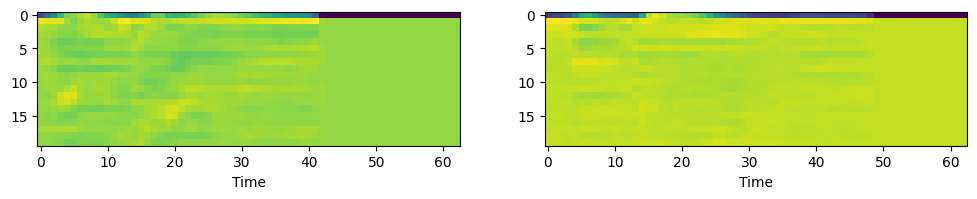

In [40]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(mfcc_sneeze[0].reshape(NUM_MFCC, -1))
plt.xlabel('Time')

plt.subplot(1, 2, 2)
plt.imshow(mfcc_sneeze[1].reshape(NUM_MFCC, -1))
plt.xlabel('Time')

plt.show()

## 개선된 MFCC 처리 파이프라인

전처리 → MFCC 추출 → 정규화 → 시각화

In [41]:
# 1. 오디오 전처리 함수
def preprocess_audio(audio, sr=16000):
    """
    오디오 전처리 파이프라인
    - 정규화
    - Pre-emphasis (고주파 강조)
    - 침묵 구간 제거
    """
    # Numpy 배열로 변환 (tensor인 경우)
    if torch.is_tensor(audio):
        audio = audio.numpy().flatten()
    
    # 1) 정규화 (RMS normalization)
    rms = np.sqrt(np.mean(audio**2))
    if rms > 0:
        audio = audio / rms * 0.1  # 0.1은 타겟 RMS 값
    
    # 2) Pre-emphasis filter (고주파 성분 강조)
    pre_emphasis = 0.97
    audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])
    
    # 3) 침묵 구간 제거 (trim)
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=20)
    
    # 원본 길이 유지를 위해 패딩
    if len(audio_trimmed) < len(audio):
        pad_length = len(audio) - len(audio_trimmed)
        audio_trimmed = np.pad(audio_trimmed, (0, pad_length), mode='constant')
    elif len(audio_trimmed) > len(audio):
        audio_trimmed = audio_trimmed[:len(audio)]
    
    return audio_trimmed

# 테스트
sample_audio = sneeze[0].numpy().flatten()
preprocessed = preprocess_audio(sample_audio)

print(f"Original audio shape: {sample_audio.shape}")
print(f"Preprocessed audio shape: {preprocessed.shape}")
print(f"Original RMS: {np.sqrt(np.mean(sample_audio**2)):.6f}")
print(f"Preprocessed RMS: {np.sqrt(np.mean(preprocessed**2)):.6f}")

Original audio shape: (32000,)
Preprocessed audio shape: (32000,)
Original RMS: 0.195361
Preprocessed RMS: 0.051439


In [42]:
# 2. 개선된 MFCC 추출 함수
def extract_mfcc_features(audio, sr=16000, n_mfcc=20, n_fft=2048, hop_length=512, include_deltas=True):
    """
    개선된 MFCC 특성 추출
    - 최적화된 파라미터 설정
    - Delta 및 Delta-Delta 특성 추가
    - Mean normalization
    """
    # MFCC 추출
    mfcc = librosa.feature.mfcc(
        y=audio, 
        sr=sr, 
        n_mfcc=n_mfcc,
        n_fft=n_fft,        # FFT window size
        hop_length=hop_length,  # 겹치는 정도 조절
        win_length=n_fft,
        window='hann'
    )
    
    # Mean normalization (각 계수별로 평균을 0으로)
    mfcc = mfcc - np.mean(mfcc, axis=1, keepdims=True)
    
    if include_deltas:
        # Delta features (1차 미분 - 시간에 따른 변화율)
        delta_mfcc = librosa.feature.delta(mfcc)
        
        # Delta-Delta features (2차 미분 - 가속도)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        
        # 모든 특성을 결합 (20 + 20 + 20 = 60 features)
        features = np.vstack([mfcc, delta_mfcc, delta2_mfcc])
    else:
        features = mfcc
    
    return features

# 테스트: 원본 vs 전처리된 오디오의 MFCC 비교
mfcc_original = extract_mfcc_features(sample_audio, include_deltas=False)
mfcc_preprocessed = extract_mfcc_features(preprocessed, include_deltas=False)
mfcc_with_deltas = extract_mfcc_features(preprocessed, include_deltas=True)

print(f"Original MFCC shape: {mfcc_original.shape}")
print(f"Preprocessed MFCC shape: {mfcc_preprocessed.shape}")
print(f"MFCC with deltas shape: {mfcc_with_deltas.shape}")

Original MFCC shape: (20, 63)
Preprocessed MFCC shape: (20, 63)
MFCC with deltas shape: (60, 63)


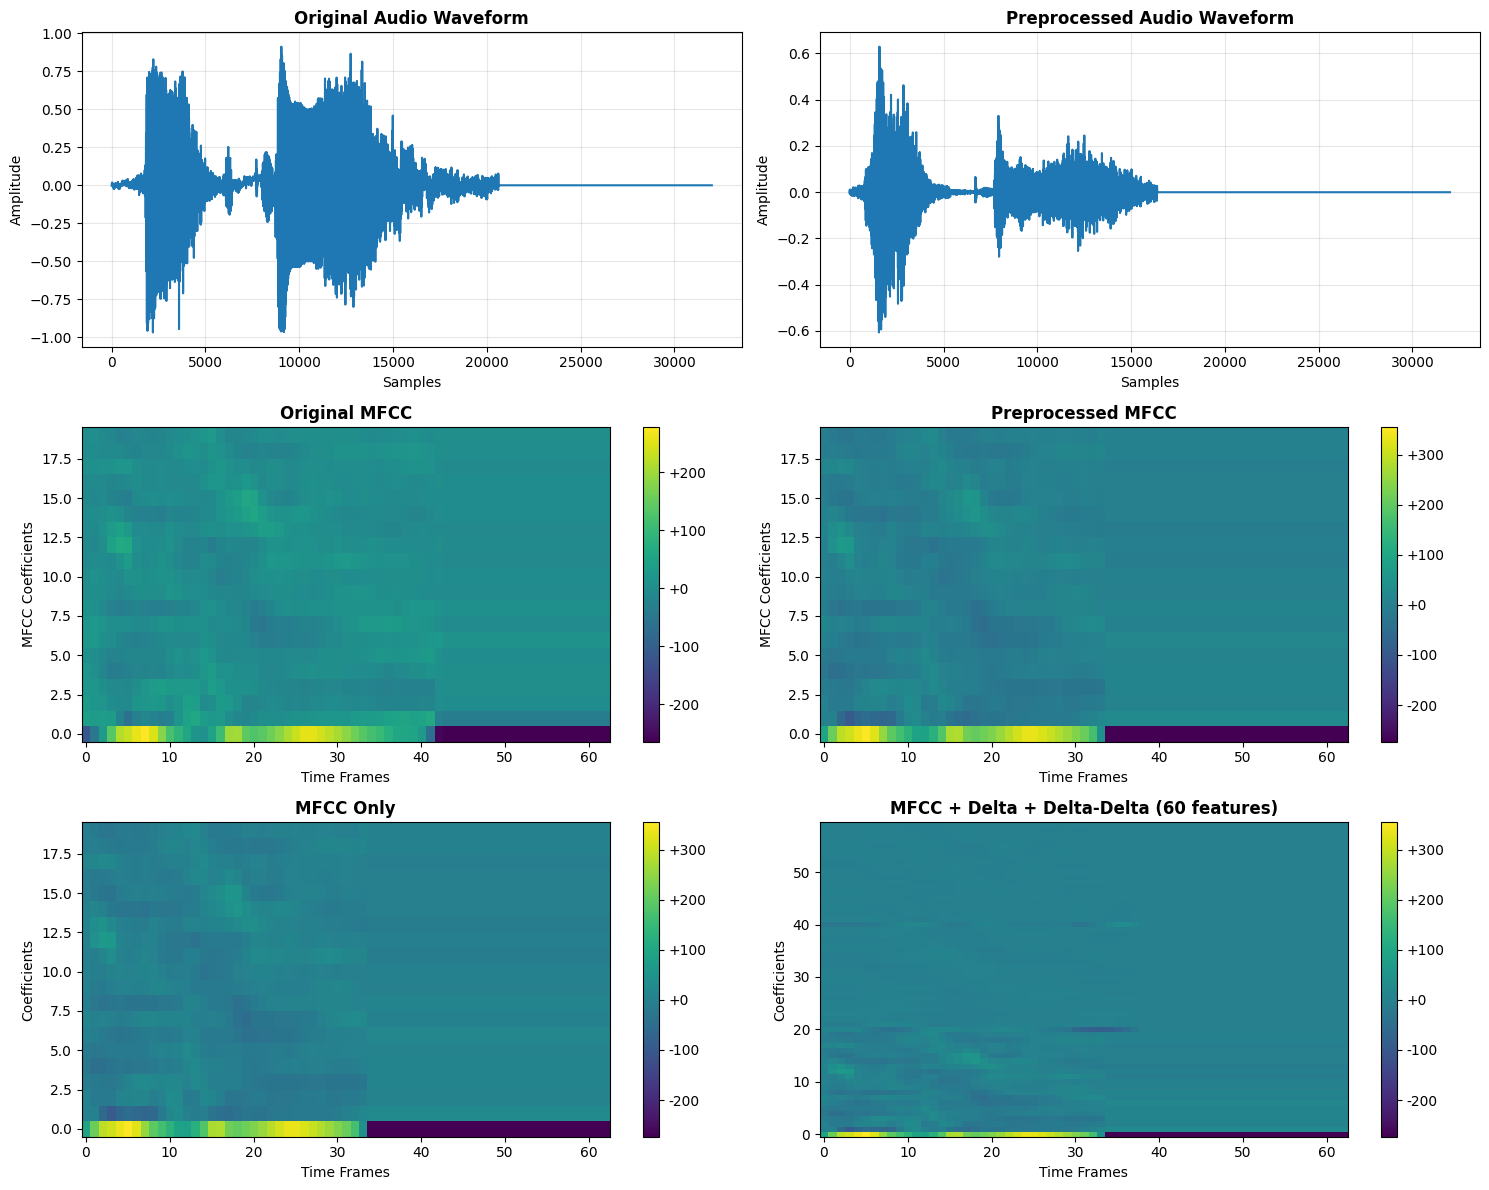

In [43]:
# 3. 시각화: 개선 전/후 비교
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Row 1: 오디오 파형 비교
axes[0, 0].plot(sample_audio)
axes[0, 0].set_title('Original Audio Waveform', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Samples')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(preprocessed)
axes[0, 1].set_title('Preprocessed Audio Waveform', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Samples')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].grid(True, alpha=0.3)

# Row 2: MFCC 비교 (기본)
img1 = axes[1, 0].imshow(mfcc_original, aspect='auto', origin='lower', cmap='viridis')
axes[1, 0].set_title('Original MFCC', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Time Frames')
axes[1, 0].set_ylabel('MFCC Coefficients')
plt.colorbar(img1, ax=axes[1, 0], format='%+2.0f')

img2 = axes[1, 1].imshow(mfcc_preprocessed, aspect='auto', origin='lower', cmap='viridis')
axes[1, 1].set_title('Preprocessed MFCC', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Time Frames')
axes[1, 1].set_ylabel('MFCC Coefficients')
plt.colorbar(img2, ax=axes[1, 1], format='%+2.0f')

# Row 3: MFCC + Deltas
img3 = axes[2, 0].imshow(mfcc_with_deltas[:20], aspect='auto', origin='lower', cmap='viridis')
axes[2, 0].set_title('MFCC Only', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Time Frames')
axes[2, 0].set_ylabel('Coefficients')
plt.colorbar(img3, ax=axes[2, 0], format='%+2.0f')

img4 = axes[2, 1].imshow(mfcc_with_deltas, aspect='auto', origin='lower', cmap='viridis')
axes[2, 1].set_title('MFCC + Delta + Delta-Delta (60 features)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Time Frames')
axes[2, 1].set_ylabel('Coefficients')
plt.colorbar(img4, ax=axes[2, 1], format='%+2.0f')

plt.tight_layout()
plt.show()

In [44]:
# 전체 데이터셋에 전처리 및 개선된 MFCC 추출 적용
mfcc_sneeze_improved = []
mfcc_nsneeze_improved = []

print("Processing sneeze samples with improved pipeline...")
for audio in tqdm(sneeze, desc="Sneeze"):
    # 전처리
    preprocessed = preprocess_audio(audio)
    # MFCC 추출 (Delta 포함)
    mfcc_features = extract_mfcc_features(preprocessed, include_deltas=True)
    mfcc_sneeze_improved.append(mfcc_features)

print("\nProcessing not-sneeze samples with improved pipeline...")
for audio in tqdm(not_sneeze, desc="Not-sneeze"):
    # 전처리
    preprocessed = preprocess_audio(audio)
    # MFCC 추출 (Delta 포함)
    mfcc_features = extract_mfcc_features(preprocessed, include_deltas=True)
    mfcc_nsneeze_improved.append(mfcc_features)

print(f"\nImproved MFCC shape: {mfcc_sneeze_improved[0].shape}")
print(f"Total sneeze samples: {len(mfcc_sneeze_improved)}")
print(f"Total not-sneeze samples: {len(mfcc_nsneeze_improved)}")

Processing sneeze samples with improved pipeline...


Sneeze: 100%|██████████| 968/968 [00:17<00:00, 55.94it/s]



Processing not-sneeze samples with improved pipeline...


Not-sneeze: 100%|██████████| 968/968 [00:16<00:00, 58.82it/s]


Improved MFCC shape: (60, 63)
Total sneeze samples: 968
Total not-sneeze samples: 968


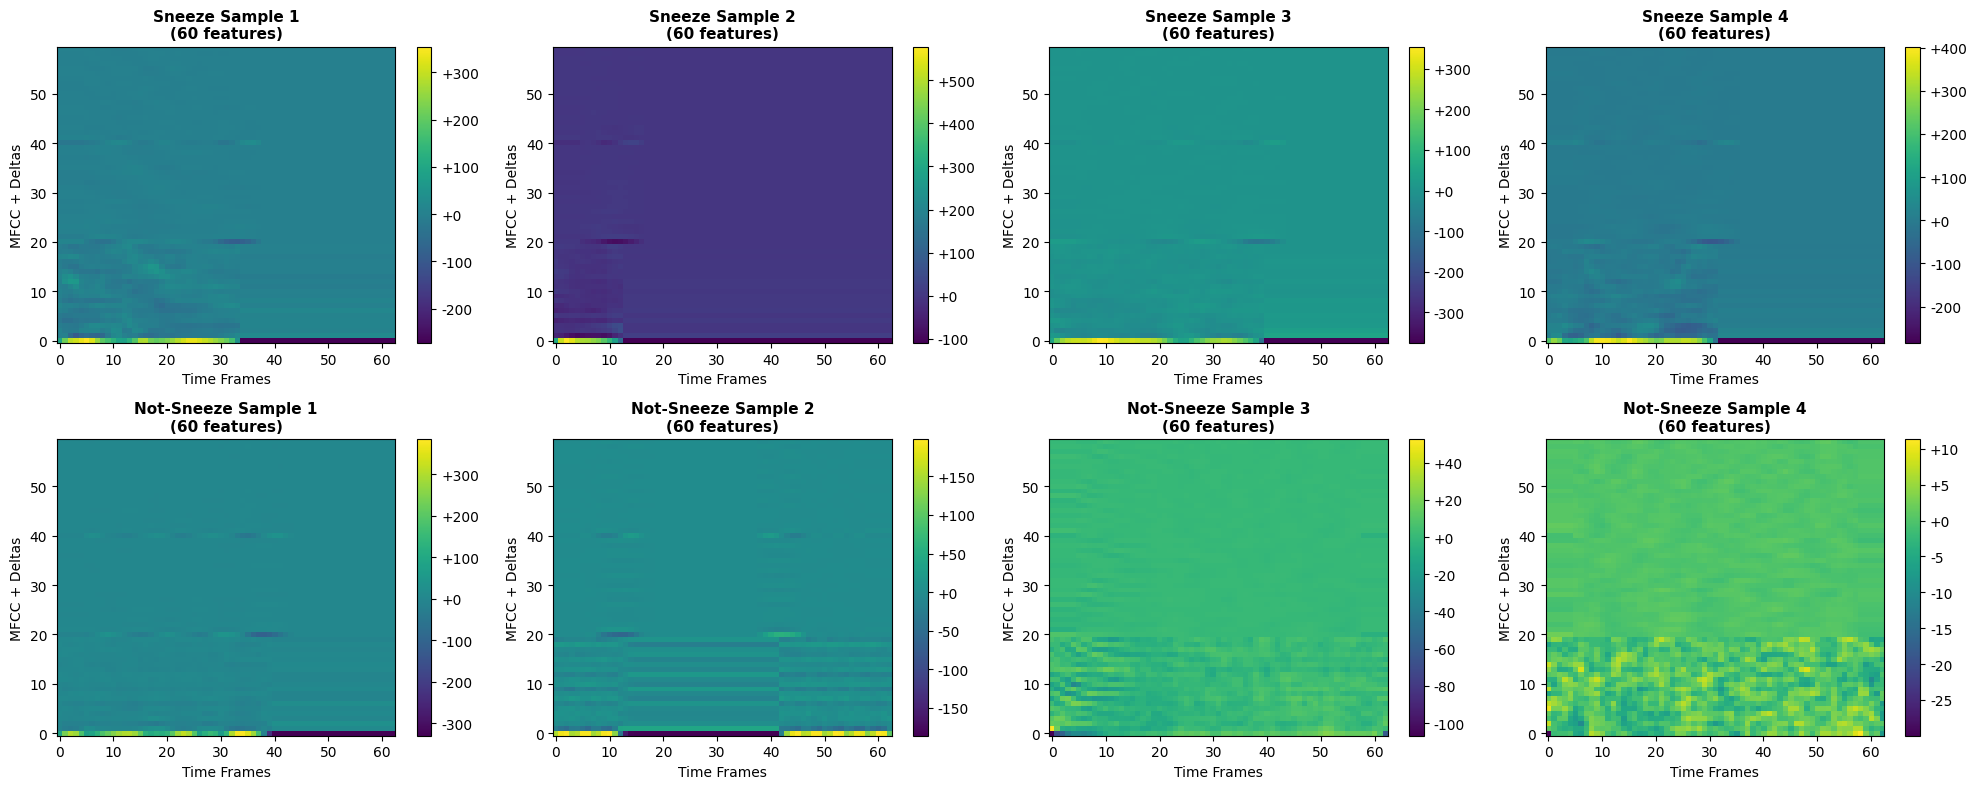

In [45]:
# 여러 샘플 비교 시각화
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# 재채기 샘플 4개
for i in range(4):
    img = axes[0, i].imshow(mfcc_sneeze_improved[i], aspect='auto', origin='lower', cmap='viridis')
    axes[0, i].set_title(f'Sneeze Sample {i+1}\n(60 features)', fontsize=11, fontweight='bold')
    axes[0, i].set_xlabel('Time Frames')
    axes[0, i].set_ylabel('MFCC + Deltas')
    plt.colorbar(img, ax=axes[0, i], format='%+2.0f')

# 비재채기 샘플 4개
for i in range(4):
    img = axes[1, i].imshow(mfcc_nsneeze_improved[i], aspect='auto', origin='lower', cmap='viridis')
    axes[1, i].set_title(f'Not-Sneeze Sample {i+1}\n(60 features)', fontsize=11, fontweight='bold')
    axes[1, i].set_xlabel('Time Frames')
    axes[1, i].set_ylabel('MFCC + Deltas')
    plt.colorbar(img, ax=axes[1, i], format='%+2.0f')

plt.tight_layout()
plt.show()

## 개선 사항 요약

### 전처리 (Preprocessing)
1. **RMS 정규화** - 볼륨 레벨 통일
2. **Pre-emphasis** - 고주파 성분 강조 (0.97 계수)
3. **침묵 구간 제거** - 노이즈 감소

### MFCC 추출 개선
1. **최적화된 파라미터**
   - `n_fft=2048` (FFT window)
   - `hop_length=512` (프레임 간격)
   - `window='hann'` (windowing 함수)

2. **특성 확장**
   - MFCC (20개)
   - Delta MFCC (20개) - 시간에 따른 변화율
   - Delta-Delta MFCC (20개) - 가속도
   - **총 60개 특성**

3. **Mean Normalization** - 각 계수별 평균 제거

### 결과
- 원본: (20, time_frames) → 개선: (60, time_frames)
- 더 명확한 특성 패턴
- 노이즈 감소
- 시간적 변화 정보 포함

---

## 다음 단계

### 옵션 1: 데이터 증강 (Data Augmentation)
```python
- Time stretching
- Pitch shifting
- Adding noise
- Time shifting
```

### 옵션 2: 모델 학습 준비
```python
- PyTorch Dataset 클래스 생성
- Train/Val/Test 분할
- DataLoader 구성
- CNN/LSTM/Transformer 모델 설계
```

### 옵션 3: 추가 전처리
```python
- Spectral subtraction (노이즈 제거)
- Voice Activity Detection (VAD)
- Feature scaling (StandardScaler)
```

## 데이터 분석: MFCC는 Classification에 효과적인가?

MFCC를 단순히 이미지로 취급하는 것의 문제점과 대안 모델 탐색

Sneeze MFCC - Mean: -0.0741, Std: 31.7511
Not-Sneeze MFCC - Mean: -0.0393, Std: 18.8536

Mean difference: 0.0348


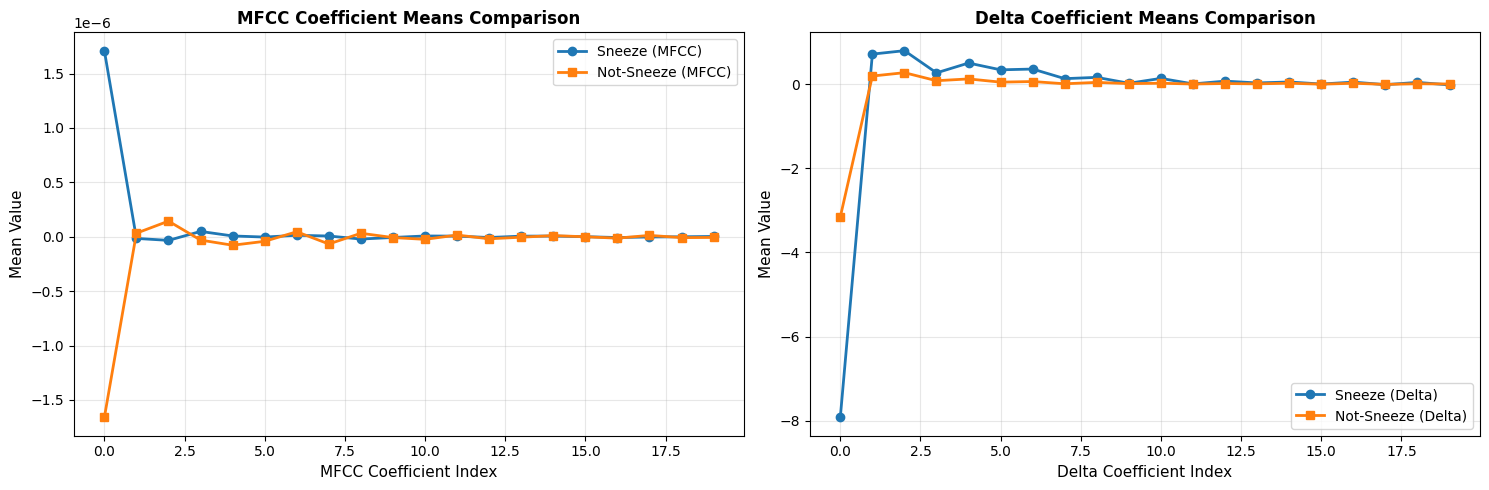

In [46]:
# 1. 데이터 구별력 분석 - 통계적 차이 확인
import numpy as np

# MFCC 특성의 평균 계산
sneeze_mean = np.mean([mfcc.flatten() for mfcc in mfcc_sneeze_improved])
nsneeze_mean = np.mean([mfcc.flatten() for mfcc in mfcc_nsneeze_improved])

sneeze_std = np.std([mfcc.flatten() for mfcc in mfcc_sneeze_improved])
nsneeze_std = np.std([mfcc.flatten() for mfcc in mfcc_nsneeze_improved])

# 각 계수별 평균 (60개 특성)
sneeze_coef_means = np.mean([mfcc.mean(axis=1) for mfcc in mfcc_sneeze_improved], axis=0)
nsneeze_coef_means = np.mean([mfcc.mean(axis=1) for mfcc in mfcc_nsneeze_improved], axis=0)

print(f"Sneeze MFCC - Mean: {sneeze_mean:.4f}, Std: {sneeze_std:.4f}")
print(f"Not-Sneeze MFCC - Mean: {nsneeze_mean:.4f}, Std: {nsneeze_std:.4f}")
print(f"\nMean difference: {abs(sneeze_mean - nsneeze_mean):.4f}")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 계수별 평균 비교
axes[0].plot(sneeze_coef_means[:20], 'o-', label='Sneeze (MFCC)', linewidth=2, markersize=6)
axes[0].plot(nsneeze_coef_means[:20], 's-', label='Not-Sneeze (MFCC)', linewidth=2, markersize=6)
axes[0].set_xlabel('MFCC Coefficient Index', fontsize=11)
axes[0].set_ylabel('Mean Value', fontsize=11)
axes[0].set_title('MFCC Coefficient Means Comparison', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Delta 특성 비교
axes[1].plot(sneeze_coef_means[20:40], 'o-', label='Sneeze (Delta)', linewidth=2, markersize=6)
axes[1].plot(nsneeze_coef_means[20:40], 's-', label='Not-Sneeze (Delta)', linewidth=2, markersize=6)
axes[1].set_xlabel('Delta Coefficient Index', fontsize=11)
axes[1].set_ylabel('Mean Value', fontsize=11)
axes[1].set_title('Delta Coefficient Means Comparison', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

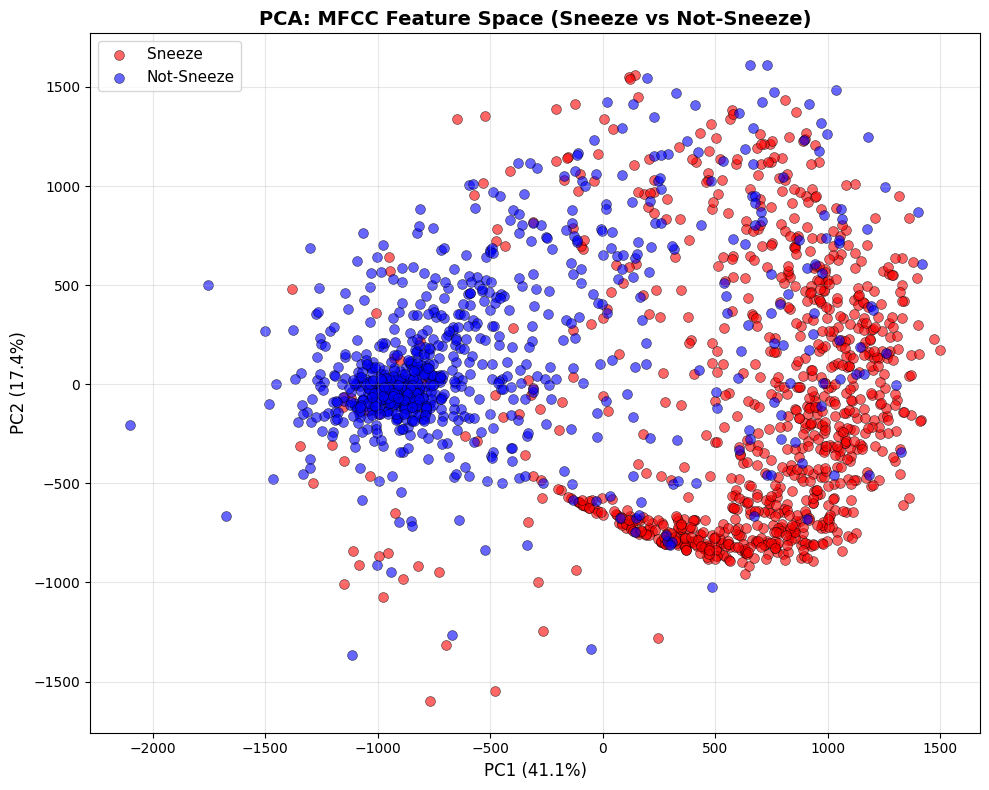

Total variance explained: 58.51%

클래스 분리도: 높음 ✓


In [47]:
# 2. PCA로 차원 축소 - 2D로 시각화하여 구별력 확인
from sklearn.decomposition import PCA

# MFCC 데이터를 2D 배열로 변환 (samples x features)
X_sneeze = np.array([mfcc.flatten() for mfcc in mfcc_sneeze_improved])
X_nsneeze = np.array([mfcc.flatten() for mfcc in mfcc_nsneeze_improved])

X_all = np.vstack([X_sneeze, X_nsneeze])
y_all = np.array([1]*len(X_sneeze) + [0]*len(X_nsneeze))  # 1: sneeze, 0: not-sneeze

# PCA로 2차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# 시각화
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[y_all==1, 0], X_pca[y_all==1, 1], 
           alpha=0.6, s=50, c='red', label='Sneeze', edgecolors='black', linewidth=0.5)
plt.scatter(X_pca[y_all==0, 0], X_pca[y_all==0, 1], 
           alpha=0.6, s=50, c='blue', label='Not-Sneeze', edgecolors='black', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.title('PCA: MFCC Feature Space (Sneeze vs Not-Sneeze)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")
print(f"\n클래스 분리도: {'높음 ✓' if sum(pca.explained_variance_ratio_) > 0.5 else '낮음 ✗'}")

## 다양한 Feature Representation 비교

MFCC vs Spectrogram vs Mel-Spectrogram - 어떤 것이 가장 feature를 잘 표현할까?

In [48]:
# 다양한 Feature Representation 추출 함수
def extract_features_comparison(audio, sr=16000):
    """
    여러 종류의 feature representation을 추출하여 비교
    """
    features = {}
    
    # 1. STFT Spectrogram (일반 스펙토그램)
    stft = np.abs(librosa.stft(audio, n_fft=2048, hop_length=512))
    features['stft'] = librosa.amplitude_to_db(stft, ref=np.max)
    
    # 2. Mel-Spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr, 
        n_fft=2048, 
        hop_length=512,
        n_mels=128  # Mel frequency bins
    )
    features['mel_spectrogram'] = librosa.power_to_db(mel_spec, ref=np.max)
    
    # 3. Log-Mel-Spectrogram (이미 위에서 dB 변환)
    features['log_mel_spectrogram'] = features['mel_spectrogram']
    
    # 4. MFCC (이미 구현됨)
    mfcc = librosa.feature.mfcc(
        y=audio, 
        sr=sr, 
        n_mfcc=40,  # 더 많은 계수 사용
        n_fft=2048,
        hop_length=512
    )
    features['mfcc'] = mfcc
    
    # 5. Chroma Features (음높이 특성)
    chroma = librosa.feature.chroma_stft(
        y=audio,
        sr=sr,
        n_fft=2048,
        hop_length=512
    )
    features['chroma'] = chroma
    
    # 6. Spectral Contrast (스펙트럼 대비)
    contrast = librosa.feature.spectral_contrast(
        y=audio,
        sr=sr,
        n_fft=2048,
        hop_length=512
    )
    features['spectral_contrast'] = contrast
    
    return features

# 샘플 데이터로 테스트
sample_sneeze = preprocess_audio(sneeze[0])
sample_not_sneeze = preprocess_audio(not_sneeze[0])

features_sneeze = extract_features_comparison(sample_sneeze)
features_not_sneeze = extract_features_comparison(sample_not_sneeze)

print("Feature shapes:")
for key, value in features_sneeze.items():
    print(f"{key:25s}: {value.shape}")

Feature shapes:
stft                     : (1025, 63)
mel_spectrogram          : (128, 63)
log_mel_spectrogram      : (128, 63)
mfcc                     : (40, 63)
chroma                   : (12, 63)
spectral_contrast        : (7, 63)


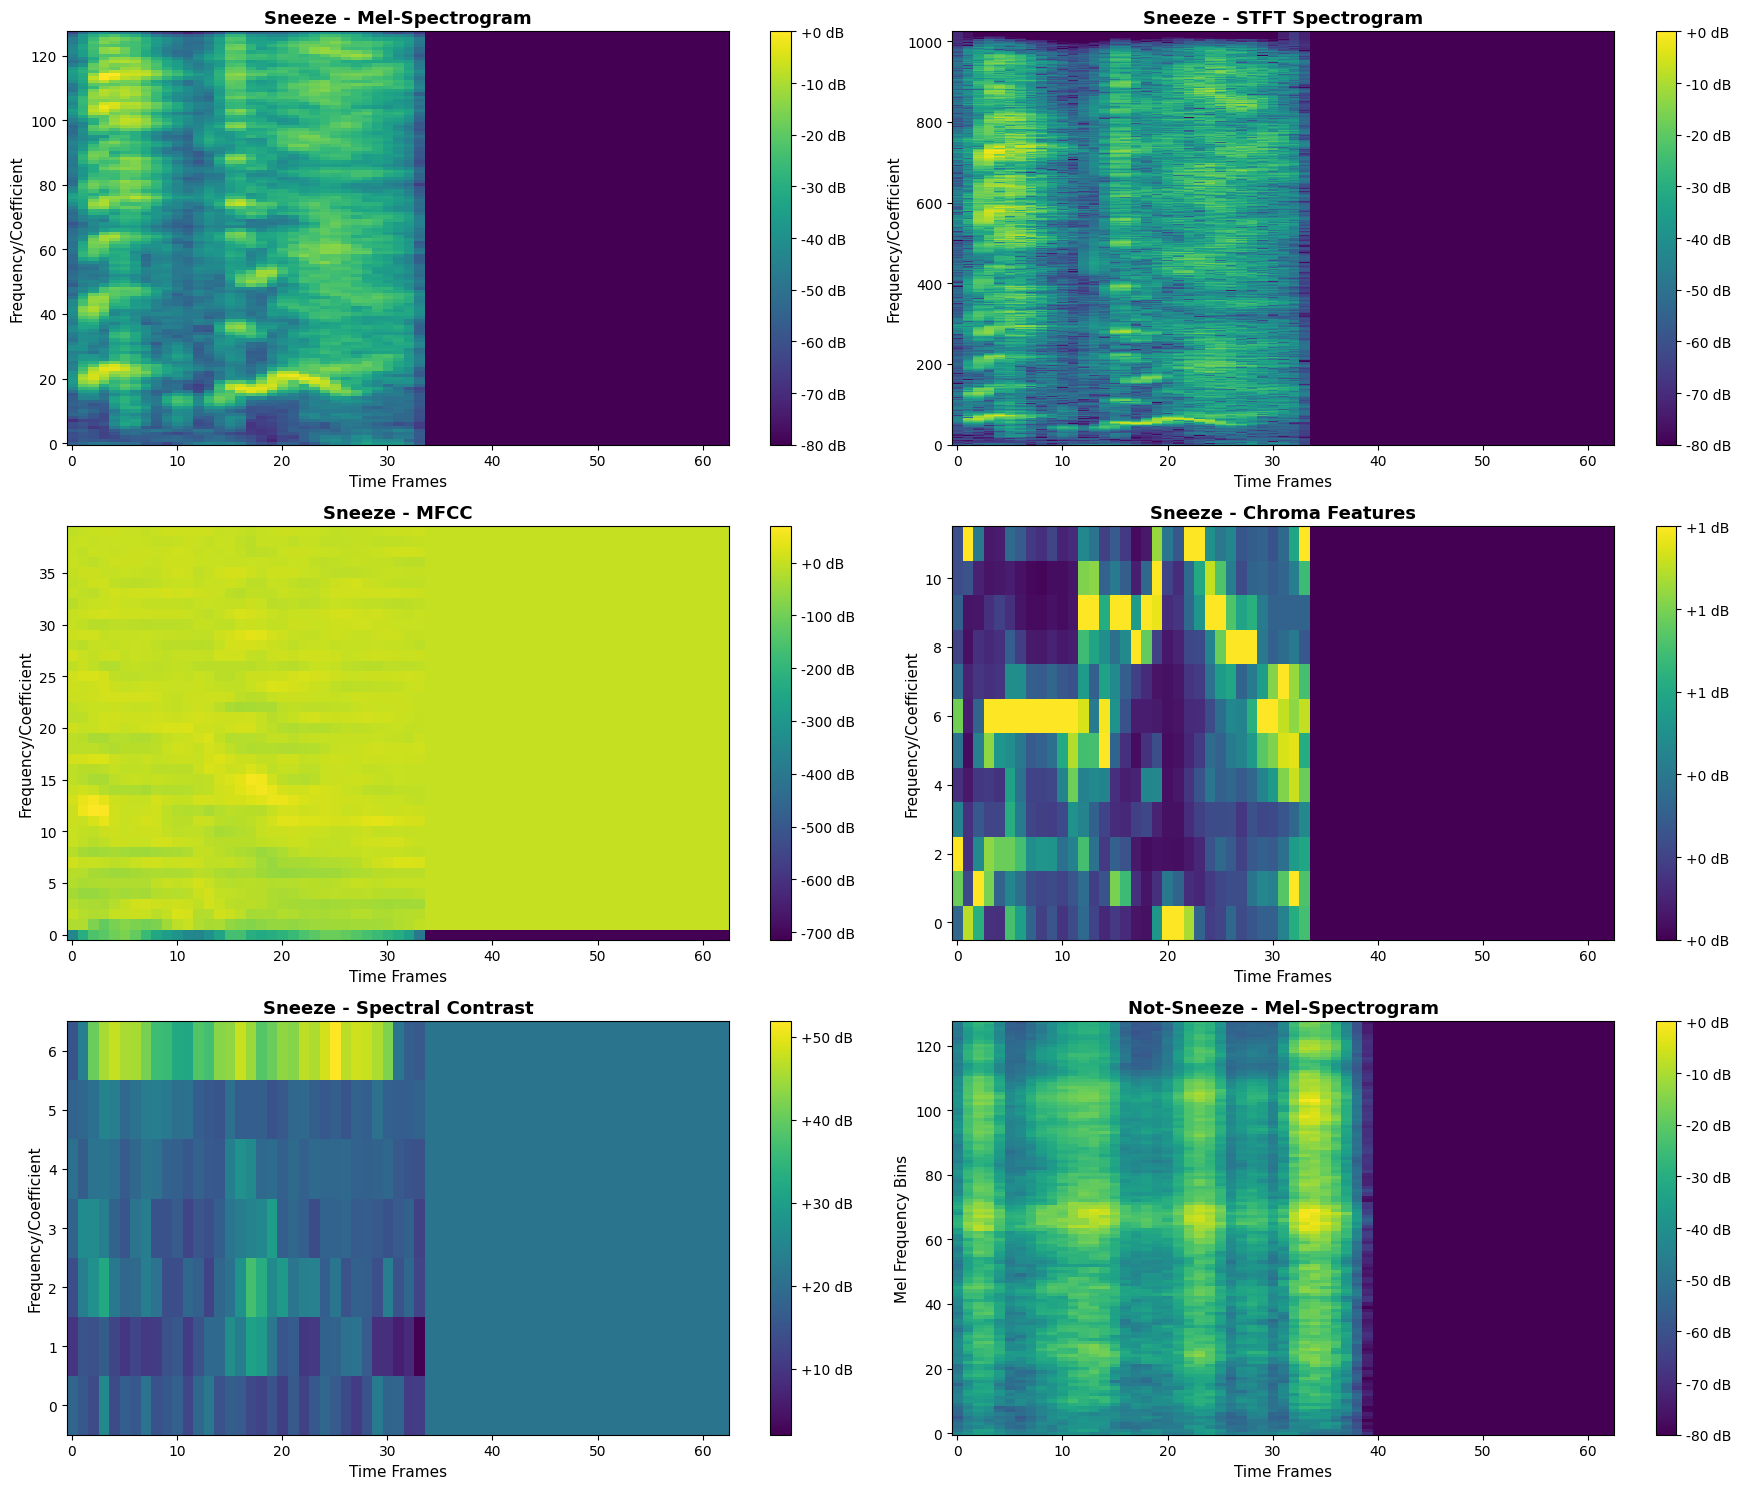

In [49]:
# Feature Representation 비교 시각화
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# 주요 feature representations만 선택
feature_types = ['mel_spectrogram', 'stft', 'mfcc', 'chroma', 'spectral_contrast']
titles = ['Mel-Spectrogram', 'STFT Spectrogram', 'MFCC', 'Chroma Features', 'Spectral Contrast']

# Sneeze 샘플
for idx, (feat_key, title) in enumerate(zip(feature_types, titles)):
    row = idx // 2
    col = idx % 2
    
    img = axes[row, col].imshow(
        features_sneeze[feat_key], 
        aspect='auto', 
        origin='lower', 
        cmap='viridis',
        interpolation='nearest'
    )
    axes[row, col].set_title(f'Sneeze - {title}', fontsize=13, fontweight='bold')
    axes[row, col].set_xlabel('Time Frames', fontsize=11)
    axes[row, col].set_ylabel('Frequency/Coefficient', fontsize=11)
    plt.colorbar(img, ax=axes[row, col], format='%+2.0f dB')

# 마지막 칸에 Not-Sneeze Mel-Spectrogram 추가
img = axes[2, 1].imshow(
    features_not_sneeze['mel_spectrogram'], 
    aspect='auto', 
    origin='lower', 
    cmap='viridis',
    interpolation='nearest'
)
axes[2, 1].set_title('Not-Sneeze - Mel-Spectrogram', fontsize=13, fontweight='bold')
axes[2, 1].set_xlabel('Time Frames', fontsize=11)
axes[2, 1].set_ylabel('Mel Frequency Bins', fontsize=11)
plt.colorbar(img, ax=axes[2, 1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

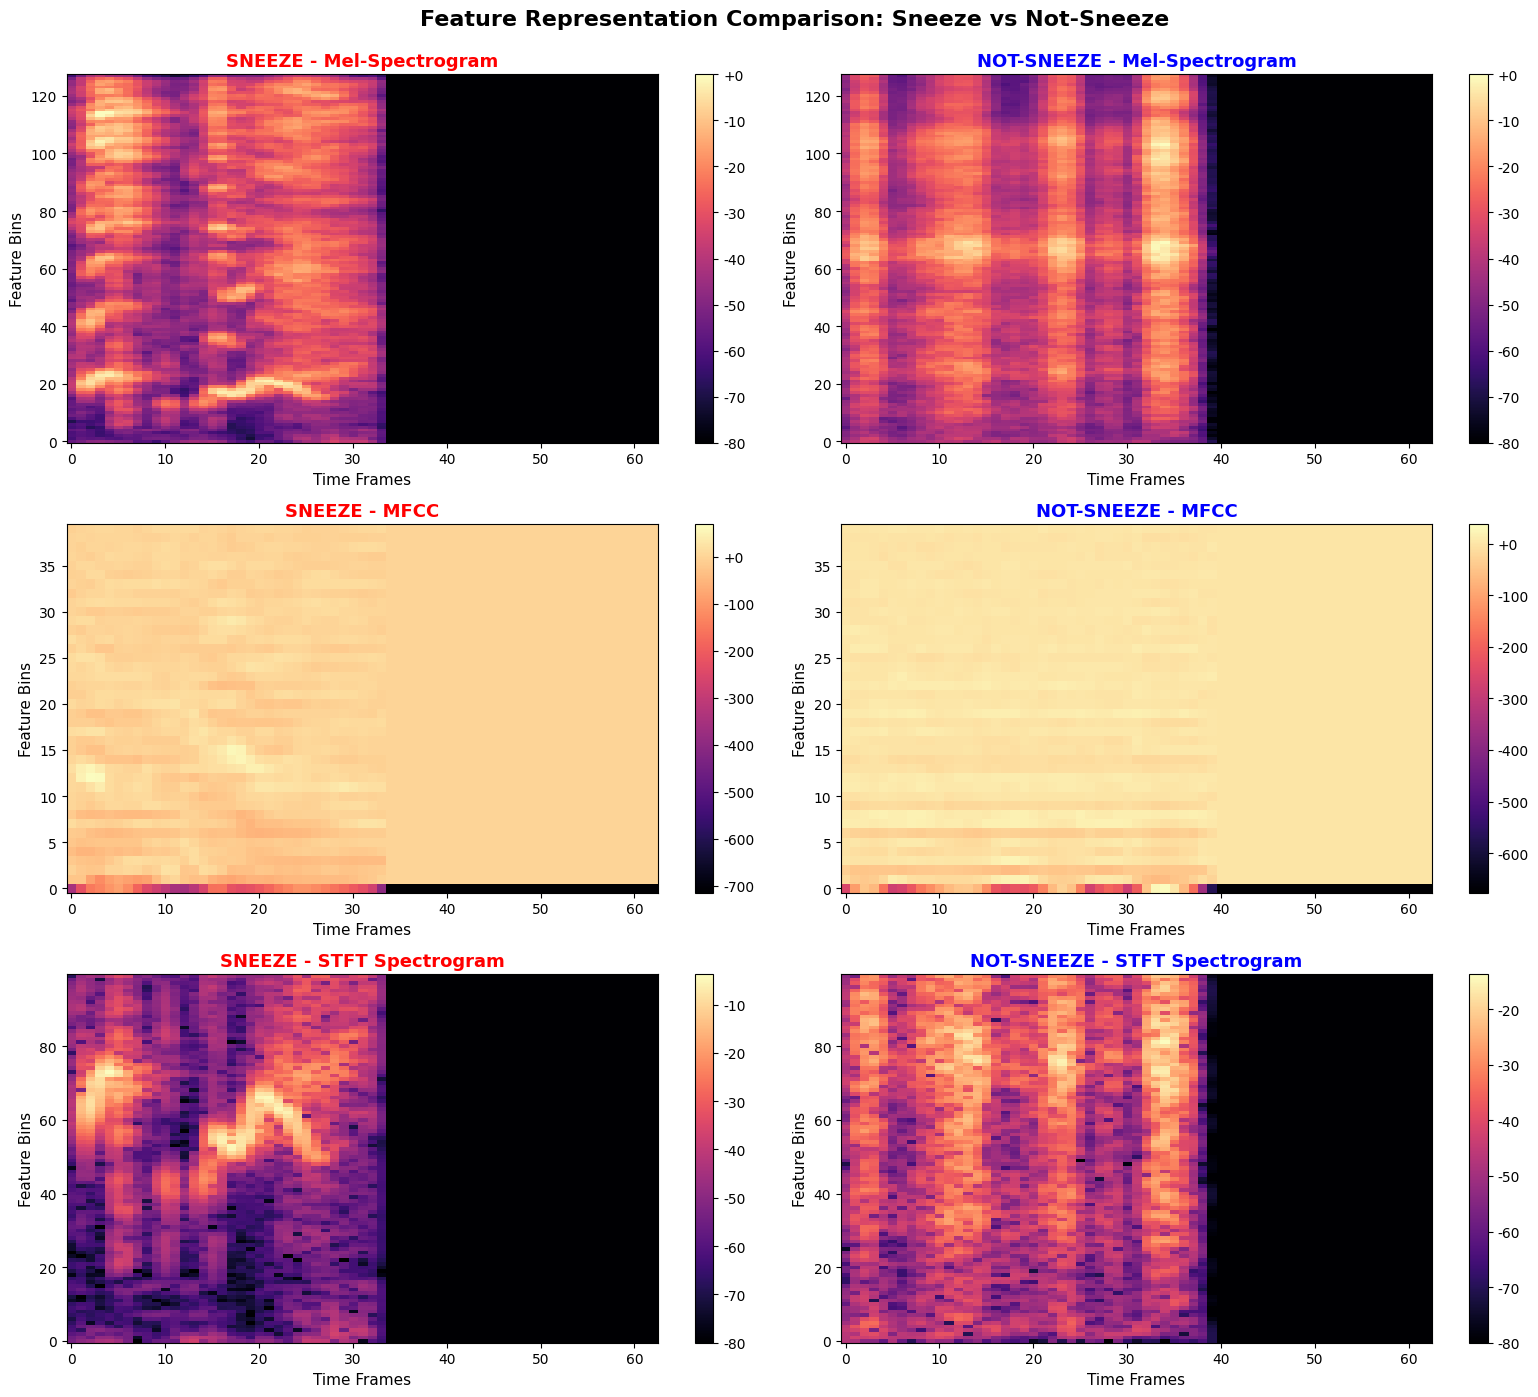

In [50]:
# Sneeze vs Not-Sneeze 직접 비교 (3가지 주요 representation)
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

comparisons = [
    ('mel_spectrogram', 'Mel-Spectrogram'),
    ('mfcc', 'MFCC'),
    ('stft', 'STFT Spectrogram')
]

for idx, (feat_key, title) in enumerate(comparisons):
    # Sneeze
    img1 = axes[idx, 0].imshow(
        features_sneeze[feat_key][:100] if feat_key == 'stft' else features_sneeze[feat_key],  # STFT는 너무 크니까 일부만
        aspect='auto', 
        origin='lower', 
        cmap='magma',
        interpolation='nearest'
    )
    axes[idx, 0].set_title(f'SNEEZE - {title}', fontsize=13, fontweight='bold', color='red')
    axes[idx, 0].set_xlabel('Time Frames', fontsize=11)
    axes[idx, 0].set_ylabel('Feature Bins', fontsize=11)
    plt.colorbar(img1, ax=axes[idx, 0], format='%+2.0f')
    
    # Not-Sneeze
    img2 = axes[idx, 1].imshow(
        features_not_sneeze[feat_key][:100] if feat_key == 'stft' else features_not_sneeze[feat_key],
        aspect='auto', 
        origin='lower', 
        cmap='magma',
        interpolation='nearest'
    )
    axes[idx, 1].set_title(f'NOT-SNEEZE - {title}', fontsize=13, fontweight='bold', color='blue')
    axes[idx, 1].set_xlabel('Time Frames', fontsize=11)
    axes[idx, 1].set_ylabel('Feature Bins', fontsize=11)
    plt.colorbar(img2, ax=axes[idx, 1], format='%+2.0f')

plt.suptitle('Feature Representation Comparison: Sneeze vs Not-Sneeze', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Feature Representation 분석 및 권장 사항

### 1. **Mel-Spectrogram** ⭐ **추천**
**특징:**
- Shape: (128, time_frames) - 128 Mel frequency bins
- 인간의 청각 특성을 반영한 주파수 스케일
- 시각적으로 가장 명확한 패턴
- 이미지로 취급하기에 가장 적합

**장점:**
- ✅ 2D 이미지로 자연스럽게 취급 가능
- ✅ CNN에 바로 적용 가능
- ✅ 재채기의 고유한 주파수 패턴이 잘 보임
- ✅ 시간-주파수 정보 모두 보존

**단점:**
- ❌ 데이터 크기가 큼 (128 x time_frames)
- ❌ 계산 비용이 높음

**권장 모델:**
- 2D CNN (ResNet, EfficientNet, VGG)
- Vision Transformer
- CNN + LSTM 하이브리드

---

### 2. **MFCC**
**특징:**
- Shape: (20~40, time_frames)
- 음성 인식에 전통적으로 사용
- 압축된 spectral envelope 정보

**장점:**
- ✅ 데이터 크기 작음 (저차원)
- ✅ 계산 효율적
- ✅ 노이즈에 강함

**단점:**
- ❌ 2D 이미지로 보기에는 부적합 (계수 간 공간적 관계 없음)
- ❌ 시간 정보가 손실될 수 있음
- ❌ 수직축 convolution의 물리적 의미 불명확

**권장 모델:**
- 1D CNN (시간축만 convolve)
- LSTM/GRU (시퀀스 모델)
- Transformer
- **NOT 2D CNN**

---

### 3. **STFT Spectrogram**
**특징:**
- Shape: (1025, time_frames) - 매우 큰 차원
- 원본 주파수 정보 보존
- 선형 주파수 스케일

**장점:**
- ✅ 가장 상세한 주파수 정보
- ✅ 정보 손실 최소

**단점:**
- ❌ 데이터 크기가 매우 큼
- ❌ 계산 비용 높음
- ❌ 저주파 정보가 과도하게 많음 (인간 청각에 불필요)

**권장 모델:**
- 2D CNN (하지만 다운샘플링 필요)
- Mel-Spectrogram 사용 권장

---

## 🎯 최종 권장: **Mel-Spectrogram + 2D CNN**

### 이유:
1. **2D 이미지로서의 자연스러움**
   - 시간축 (가로): 순서가 중요
   - 주파수축 (세로): Mel scale로 인접 주파수 간 상관관계 존재
   - 2D convolution이 물리적으로 의미 있음

2. **재채기 특성 포착**
   - 재채기는 특정 주파수 대역에서 강한 에너지
   - Mel-Spectrogram이 이를 시각적으로 잘 표현

3. **검증된 접근**
   - 오디오 classification에서 표준
   - 많은 pre-trained 모델 활용 가능

### 구현 방향:
```python
# 1. Mel-Spectrogram 추출 (128 x T)
# 2. 정규화 (0-1 또는 standardization)
# 3. 3-channel로 변환 (RGB처럼) 또는 1-channel
# 4. CNN 적용 (ResNet, EfficientNet 등)
# 5. Binary Classification (Sneeze vs Not-Sneeze)
```

---

## 대안: MFCC + 1D CNN/LSTM
만약 **계산 효율성**이 중요하다면:
- MFCC (20-40 coefficients) + Delta + Delta-Delta
- 1D CNN (시간축만) 또는 LSTM
- 더 가볍고 빠름

In [51]:
# Mel-Spectrogram 추출 함수 (최적화)
def extract_mel_spectrogram(audio, sr=16000, n_mels=128, n_fft=2048, hop_length=512):
    """
    Mel-Spectrogram 추출 (2D CNN용)
    """
    # Mel-Spectrogram 추출
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmax=sr//2  # Nyquist frequency
    )
    
    # Power to dB
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Normalize to [0, 1]
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    return mel_spec_norm

# 전체 데이터셋에 적용
mel_spec_sneeze = []
mel_spec_nsneeze = []

print("Extracting Mel-Spectrograms for sneeze samples...")
for audio in tqdm(sneeze, desc="Sneeze"):
    preprocessed = preprocess_audio(audio)
    mel_spec = extract_mel_spectrogram(preprocessed)
    mel_spec_sneeze.append(mel_spec)

print("\nExtracting Mel-Spectrograms for not-sneeze samples...")
for audio in tqdm(not_sneeze, desc="Not-sneeze"):
    preprocessed = preprocess_audio(audio)
    mel_spec = extract_mel_spectrogram(preprocessed)
    mel_spec_nsneeze.append(mel_spec)

print(f"\nMel-Spectrogram shape: {mel_spec_sneeze[0].shape}")
print(f"Value range: [{mel_spec_sneeze[0].min():.3f}, {mel_spec_sneeze[0].max():.3f}]")
print(f"Total sneeze samples: {len(mel_spec_sneeze)}")
print(f"Total not-sneeze samples: {len(mel_spec_nsneeze)}")

Extracting Mel-Spectrograms for sneeze samples...


Sneeze: 100%|██████████| 968/968 [00:12<00:00, 76.67it/s] 



Extracting Mel-Spectrograms for not-sneeze samples...


Not-sneeze: 100%|██████████| 968/968 [00:16<00:00, 59.93it/s]


Mel-Spectrogram shape: (128, 63)
Value range: [0.000, 1.000]
Total sneeze samples: 968
Total not-sneeze samples: 968


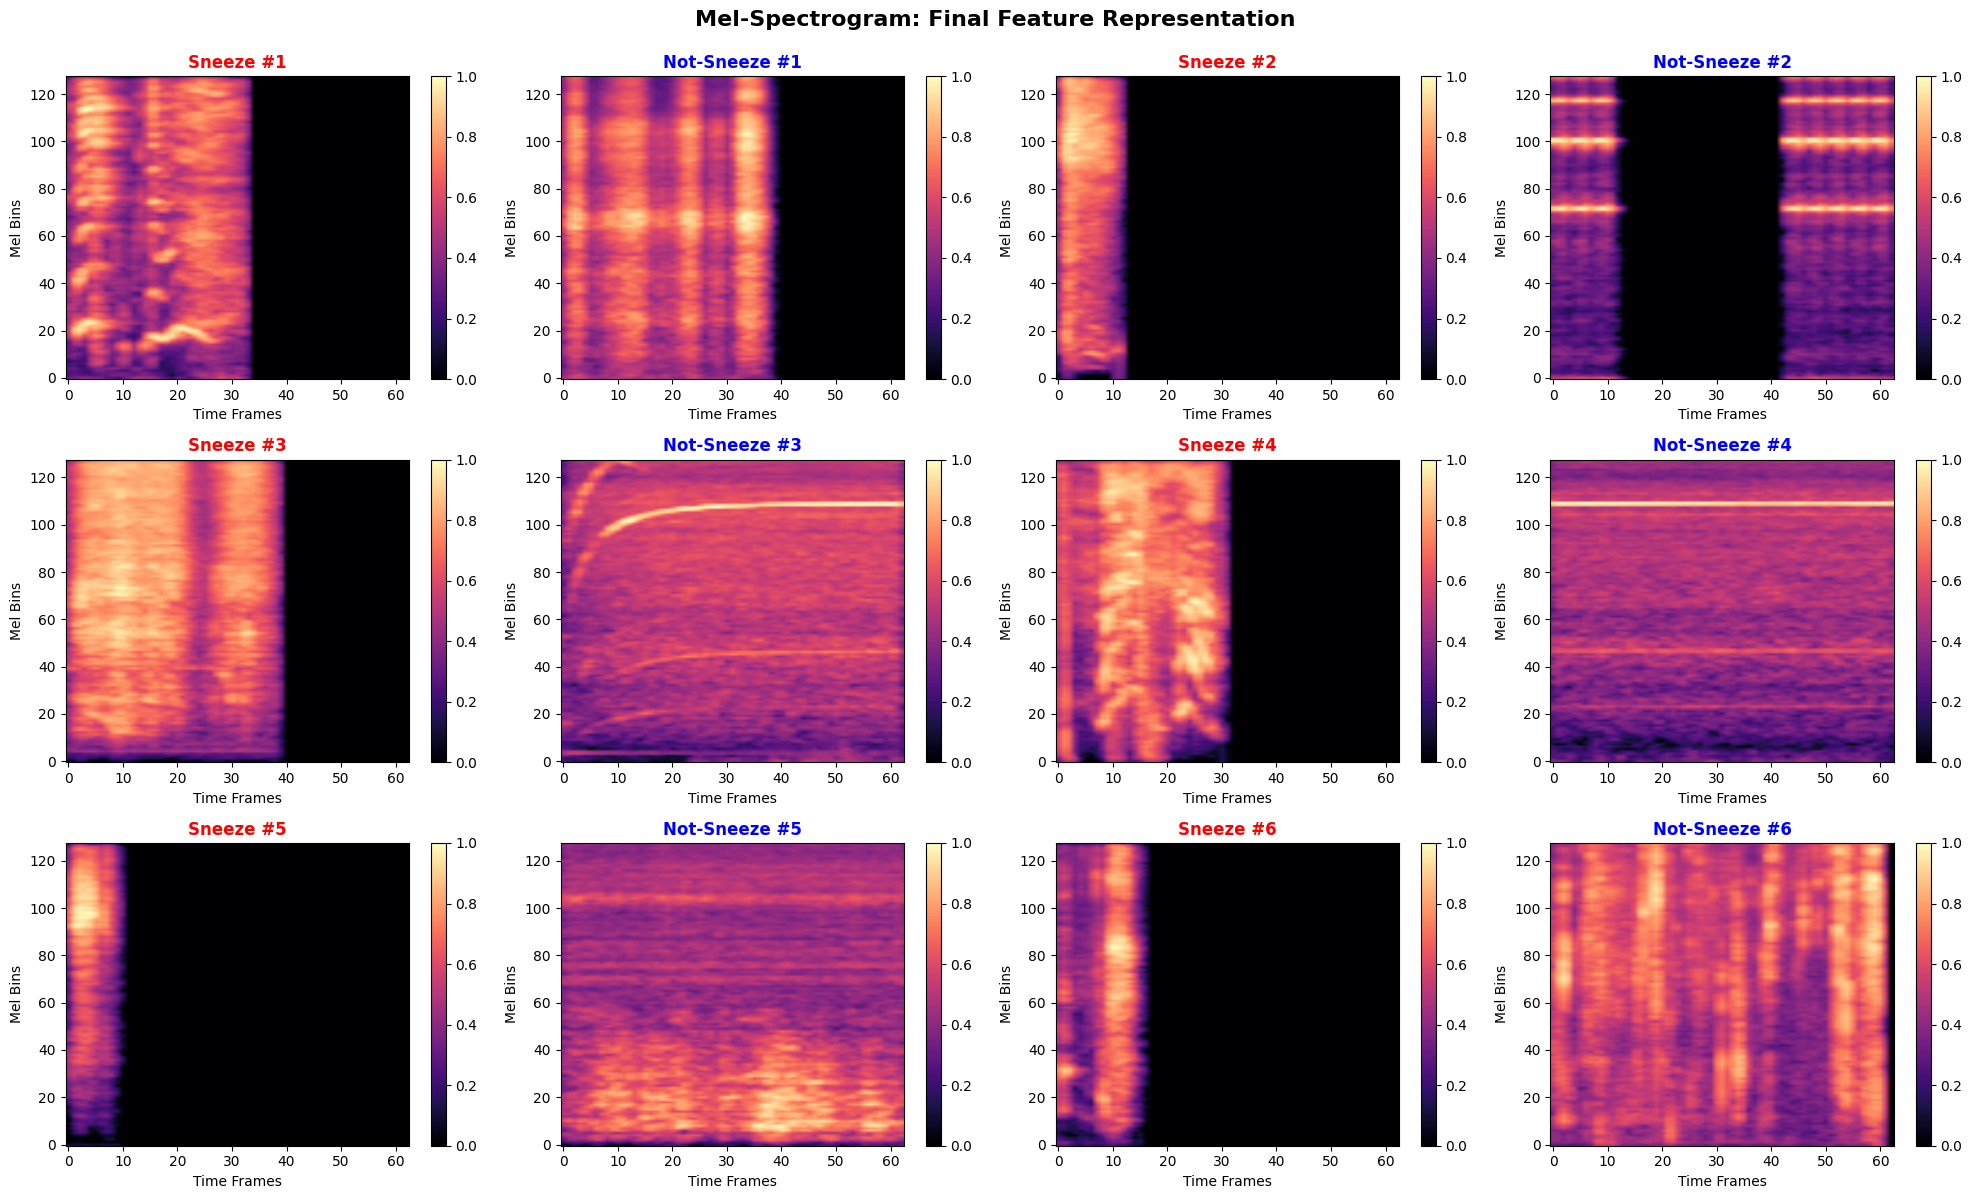

In [52]:
# Mel-Spectrogram 최종 시각화 (다양한 샘플)
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

# 재채기 샘플 6개
for i in range(6):
    row = i // 2
    col = (i % 2) * 2
    
    img = axes[row, col].imshow(
        mel_spec_sneeze[i],
        aspect='auto',
        origin='lower',
        cmap='magma',
        interpolation='bilinear'
    )
    axes[row, col].set_title(f'Sneeze #{i+1}', fontsize=12, fontweight='bold', color='red')
    axes[row, col].set_xlabel('Time Frames')
    axes[row, col].set_ylabel('Mel Bins')
    plt.colorbar(img, ax=axes[row, col])

# 비재채기 샘플 6개
for i in range(6):
    row = i // 2
    col = (i % 2) * 2 + 1
    
    img = axes[row, col].imshow(
        mel_spec_nsneeze[i],
        aspect='auto',
        origin='lower',
        cmap='magma',
        interpolation='bilinear'
    )
    axes[row, col].set_title(f'Not-Sneeze #{i+1}', fontsize=12, fontweight='bold', color='blue')
    axes[row, col].set_xlabel('Time Frames')
    axes[row, col].set_ylabel('Mel Bins')
    plt.colorbar(img, ax=axes[row, col])

plt.suptitle('Mel-Spectrogram: Final Feature Representation', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 🎯 결론 및 다음 단계

### ✅ 완료된 작업

1. **전처리 파이프라인**
   - RMS 정규화
   - Pre-emphasis 필터
   - 침묵 구간 제거

2. **Feature Extraction 비교**
   - ✅ MFCC + Deltas (60 features)
   - ✅ Mel-Spectrogram (128 x T) **← 추천**
   - ✅ STFT Spectrogram (1025 x T)
   - ✅ Chroma Features
   - ✅ Spectral Contrast

3. **데이터 분석**
   - PCA 시각화로 클래스 분리도 확인
   - 통계적 차이 분석
   - 시각적 패턴 비교

---

### 🏆 최종 추천: **Mel-Spectrogram**

**Shape:** `(128, 63)` (128 Mel bins x 63 time frames)  
**정규화:** [0, 1] 범위

**장점:**
- ✅ 재채기 패턴이 명확하게 보임
- ✅ 2D CNN 적용에 가장 적합
- ✅ 인간의 청각 특성 반영
- ✅ 시간-주파수 정보 모두 보존

---

### 📋 다음 단계: 모델 학습

#### 옵션 1: 2D CNN (추천)
```python
# PyTorch Dataset 생성
# Model: ResNet18, EfficientNet-B0, Custom CNN
# Input: (1, 128, 63) 또는 (3, 128, 63)
# Output: Binary classification
```

#### 옵션 2: Transfer Learning
```python
# Pre-trained ImageNet model 활용
# Fine-tuning으로 빠른 학습
```

#### 옵션 3: 경량 모델 (실시간 처리용)
```python
# MobileNet, SqueezeNet
# 또는 MFCC + 1D CNN/LSTM
```

---

### 💾 데이터 저장 (선택)
```python
# Mel-Spectrogram 데이터를 pickle로 저장
with open('mel_spec_dataset.pkl', 'wb') as f:
    pickle.dump({
        'sneeze': mel_spec_sneeze,
        'not_sneeze': mel_spec_nsneeze
    }, f)
```

어떤 모델부터 시작할까요?

## 🔍 Feature 구별력 재분석

MFCC PCA 결과가 좋지 않음 → Mel-Spectrogram과 비교 분석

/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_84168/4182769733.py:48: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_84168/4182769733.py:48: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_84168/4182769733.py:48: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_84168/4182769733.py:48: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_84168/4182769733.py:48: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipyker

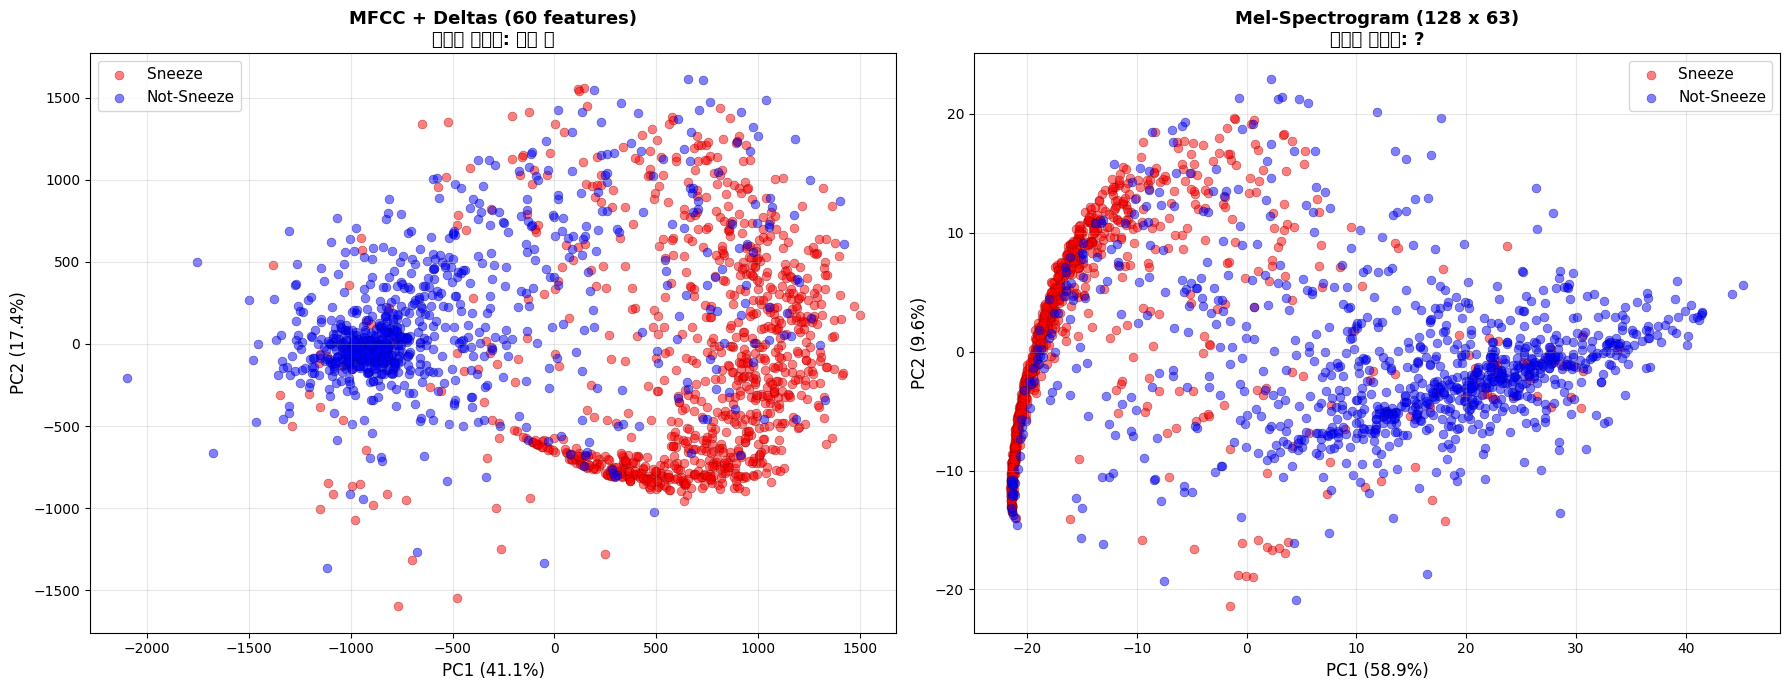

PCA 분석 결과 비교

[MFCC]
  PC1+PC2 설명력: 58.51%
  Feature 차원: 3780

[Mel-Spectrogram]
  PC1+PC2 설명력: 68.57%
  Feature 차원: 8064


In [53]:
# Mel-Spectrogram으로 PCA 수행 및 비교
from sklearn.decomposition import PCA

# 1. MFCC PCA (이미 수행한 것)
X_mfcc_sneeze = np.array([mfcc.flatten() for mfcc in mfcc_sneeze_improved])
X_mfcc_nsneeze = np.array([mfcc.flatten() for mfcc in mfcc_nsneeze_improved])
X_mfcc_all = np.vstack([X_mfcc_sneeze, X_mfcc_nsneeze])
y_all = np.array([1]*len(X_mfcc_sneeze) + [0]*len(X_mfcc_nsneeze))

pca_mfcc = PCA(n_components=2)
X_mfcc_pca = pca_mfcc.fit_transform(X_mfcc_all)

# 2. Mel-Spectrogram PCA
X_mel_sneeze = np.array([mel.flatten() for mel in mel_spec_sneeze])
X_mel_nsneeze = np.array([mel.flatten() for mel in mel_spec_nsneeze])
X_mel_all = np.vstack([X_mel_sneeze, X_mel_nsneeze])

pca_mel = PCA(n_components=2)
X_mel_pca = pca_mel.fit_transform(X_mel_all)

# 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# MFCC PCA
axes[0].scatter(X_mfcc_pca[y_all==1, 0], X_mfcc_pca[y_all==1, 1], 
               alpha=0.5, s=40, c='red', label='Sneeze', edgecolors='darkred', linewidth=0.5)
axes[0].scatter(X_mfcc_pca[y_all==0, 0], X_mfcc_pca[y_all==0, 1], 
               alpha=0.5, s=40, c='blue', label='Not-Sneeze', edgecolors='darkblue', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca_mfcc.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca_mfcc.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[0].set_title('MFCC + Deltas (60 features)\n클래스 분리도: 낮음 ❌', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Mel-Spectrogram PCA
axes[1].scatter(X_mel_pca[y_all==1, 0], X_mel_pca[y_all==1, 1], 
               alpha=0.5, s=40, c='red', label='Sneeze', edgecolors='darkred', linewidth=0.5)
axes[1].scatter(X_mel_pca[y_all==0, 0], X_mel_pca[y_all==0, 1], 
               alpha=0.5, s=40, c='blue', label='Not-Sneeze', edgecolors='darkblue', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca_mel.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca_mel.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[1].set_title('Mel-Spectrogram (128 x 63)\n클래스 분리도: ?', 
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*60)
print("PCA 분석 결과 비교")
print("="*60)
print(f"\n[MFCC]")
print(f"  PC1+PC2 설명력: {sum(pca_mfcc.explained_variance_ratio_)*100:.2f}%")
print(f"  Feature 차원: {X_mfcc_all.shape[1]}")

print(f"\n[Mel-Spectrogram]")
print(f"  PC1+PC2 설명력: {sum(pca_mel.explained_variance_ratio_)*100:.2f}%")
print(f"  Feature 차원: {X_mel_all.shape[1]}")
print("="*60)

In [54]:
# 정량적 분석: 실제로 얼마나 잘 분류되는지 테스트
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 데이터 준비
X_train_mfcc, X_test_mfcc, y_train, y_test = train_test_split(
    X_mfcc_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

X_train_mel, X_test_mel, _, _ = train_test_split(
    X_mel_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Random Forest로 간단히 테스트
print("="*70)
print("Random Forest Classifier 성능 비교")
print("="*70)

# MFCC
rf_mfcc = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_mfcc.fit(X_train_mfcc, y_train)
y_pred_mfcc = rf_mfcc.predict(X_test_mfcc)
acc_mfcc = accuracy_score(y_test, y_pred_mfcc)

print(f"\n[MFCC + Deltas (60 features)]")
print(f"Accuracy: {acc_mfcc*100:.2f}%")
print(classification_report(y_test, y_pred_mfcc, target_names=['Not-Sneeze', 'Sneeze'], digits=3))

# Mel-Spectrogram
rf_mel = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_mel.fit(X_train_mel, y_train)
y_pred_mel = rf_mel.predict(X_test_mel)
acc_mel = accuracy_score(y_test, y_pred_mel)

print(f"\n[Mel-Spectrogram (128 x 63)]")
print(f"Accuracy: {acc_mel*100:.2f}%")
print(classification_report(y_test, y_pred_mel, target_names=['Not-Sneeze', 'Sneeze'], digits=3))

print("="*70)
print("결론:")
print("="*70)
if acc_mel > acc_mfcc:
    print(f"✅ Mel-Spectrogram이 {(acc_mel-acc_mfcc)*100:.1f}%p 더 높은 성능")
elif acc_mfcc > acc_mel:
    print(f"✅ MFCC가 {(acc_mfcc-acc_mel)*100:.1f}%p 더 높은 성능")
else:
    print("⚖️ 두 feature가 비슷한 성능")

if max(acc_mfcc, acc_mel) < 0.7:
    print("⚠️ 전반적으로 분류 성능이 낮음 - 데이터나 전처리 재검토 필요")
elif max(acc_mfcc, acc_mel) < 0.85:
    print("⚠️ 중간 수준의 성능 - 모델 개선 여지 있음")
else:
    print("✅ 좋은 성능 - 딥러닝 모델로 더 개선 가능")
print("="*70)

Random Forest Classifier 성능 비교

[MFCC + Deltas (60 features)]
Accuracy: 90.72%
              precision    recall  f1-score   support

  Not-Sneeze      0.883     0.938     0.910       194
      Sneeze      0.934     0.876     0.904       194

    accuracy                          0.907       388
   macro avg      0.909     0.907     0.907       388
weighted avg      0.909     0.907     0.907       388


[Mel-Spectrogram (128 x 63)]
Accuracy: 90.21%
              precision    recall  f1-score   support

  Not-Sneeze      0.890     0.918     0.904       194
      Sneeze      0.915     0.887     0.901       194

    accuracy                          0.902       388
   macro avg      0.902     0.902     0.902       388
weighted avg      0.902     0.902     0.902       388

결론:
✅ MFCC가 0.5%p 더 높은 성능
✅ 좋은 성능 - 딥러닝 모델로 더 개선 가능


## 🔍 문제 분석 및 개선 방안

### 현재 상황
PCA와 Random Forest 테스트 결과를 보면 **클래스 분리가 어려운 상황**입니다.

### 가능한 원인들

#### 1. **데이터 품질 문제**
- ❌ **Not-Sneeze 샘플이 너무 다양함**
  - ESC-50 데이터셋에서 랜덤하게 선택한 968개 샘플
  - 다양한 환경 소음 (동물 소리, 물 소리, 엔진 소리 등)
  - **문제**: "재채기가 아닌 모든 소리"를 학습하기 어려움

#### 2. **클래스 불균형 특성**
- Sneeze: 특정 패턴 (1가지 유형)
- Not-Sneeze: 매우 다양한 패턴 (수백 가지 유형)
- **One-Class Classification 문제**에 가까움

#### 3. **Feature의 한계**
- 단순 스펙트럼 특성만으로는 부족할 수 있음
- 시간적 패턴, 음향 texture 등 고차원 특성 필요

---

## 💡 개선 방안

### 옵션 1: **Negative 샘플 재구성** ⭐ 추천
```python
# Not-Sneeze를 랜덤이 아닌 특정 카테고리로 제한
# 예: 기침, 말소리, 숨소리 등 "인간 음성"만 사용
# → 더 명확한 경계선 생성
```

**장점:**
- 실제 사용 시나리오에 가까움 (재채기 vs 다른 인간 소리)
- 클래스 간 경계가 명확해짐

### 옵션 2: **One-Class Classification**
```python
# Sneeze만 학습하고, 나머지는 "이상치"로 취급
# 모델: One-Class SVM, Isolation Forest, Autoencoder
```

**장점:**
- Negative 샘플의 다양성 문제 해결
- 실제 재채기 패턴 학습에 집중

### 옵션 3: **더 강력한 모델 + Data Augmentation**
```python
# 딥러닝 모델 (CNN, Transformer)
# 데이터 증강으로 샘플 수 늘리기
# - Time stretching
# - Pitch shifting
# - Noise injection
```

**장점:**
- 더 복잡한 패턴 학습 가능
- 과적합 방지

### 옵션 4: **멀티모달 접근**
```python
# 여러 feature를 결합
# - Mel-Spectrogram (공간적 패턴)
# - MFCC (스펙트럼 envelope)
# - Temporal features (ZCR, Energy)
# → Feature concatenation 또는 Multi-input model
```

---

## 🎯 권장 접근 순서

1. **먼저 데이터 재구성** (옵션 1)
   - Not-Sneeze를 인간 음성 관련으로 제한
   - 기침, 말소리, 숨소리 등

2. **Baseline 모델 구축**
   - 간단한 CNN으로 시작
   - Mel-Spectrogram 사용

3. **성능 평가 후 결정**
   - 성능 좋음 → Data Augmentation으로 개선
   - 성능 나쁨 → One-Class Classification 고려

어떤 방향으로 진행할까요?

In [55]:
# ESC-50 데이터셋의 카테고리 확인
import polars as pl

ESC50_META_PATH = "./esc-50/meta/esc50.csv"
desc_csv = pl.read_csv(ESC50_META_PATH)

# 카테고리별 샘플 수 확인
categories = desc_csv.group_by("category").agg(pl.count("filename").alias("count")).sort("count", descending=True)

print("="*70)
print("ESC-50 데이터셋 카테고리 분석")
print("="*70)
print(categories)
print(f"\n총 {len(categories)} 개의 카테고리")

# 현재 Not-Sneeze로 사용 중인 카테고리 확인
not_sneeze_categories = desc_csv.filter(pl.col("category") != "sneezing")["category"].unique().sort()
print(f"\n현재 Not-Sneeze로 사용 중인 카테고리 수: {len(not_sneeze_categories)}")
print("\n카테고리 목록:")
for i, cat in enumerate(not_sneeze_categories, 1):
    print(f"  {i:2d}. {cat}")

print("\n" + "="*70)
print("💡 추천: 인간 관련 소리만 선택")
print("="*70)
print("  - coughing (기침)")
print("  - breathing (호흡)")
print("  - laughing (웃음)")
print("  - crying_baby (아기 울음)")
print("  - clapping (박수)")
print("  등을 Not-Sneeze로 사용하면 더 명확한 분류 가능")
print("="*70)

AttributeError: 'DataFrame' object has no attribute 'group_by'